# 📐 Phase 2b — Modélisation de l'Élasticité-Prix
## Olist Pricing Intelligence

---

**Objectif :** Estimer l'**élasticité-prix de la demande** pour chaque catégorie de produits — c'est-à-dire mesurer de combien varie le volume de ventes lorsque le prix augmente ou diminue de 1%.

**Méthode : Régression log-log**

Le modèle standard en économétrie du pricing est :

$$\ln(Q) = \alpha + \varepsilon \cdot \ln(P) + \epsilon$$

Où :
- $Q$ = quantité vendue (volume mensuel)
- $P$ = prix moyen mensuel
- $\varepsilon$ = **élasticité-prix** (coefficient estimé)
- $\epsilon$ = terme d'erreur

**Interprétation :**

| Élasticité $\varepsilon$ | Interprétation | Stratégie |
|---|---|---|
| $\varepsilon < -1$ | Demande élastique | Baisser le prix augmente le CA |
| $-1 < \varepsilon < 0$ | Demande inélastique | Hausse de prix possible sans perte de volume |
| $\varepsilon > 0$ | Bien de Veblen / anomalie | Prix élevé = signal de qualité |

**Input :** `data/processed/olist_pricing_dataset.csv`

---

## Table des matières

1. [Imports & Configuration](#1-imports)
2. [Chargement & Préparation](#2-prep)
3. [Modélisation log-log par catégorie](#3-model)
4. [Simulation de scénarios tarifaires](#4-scenarios)
5. [Visualisations](#5-viz)
6. [Synthèse & Recommandations](#6-synthese)

---
## 1. Imports & Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
import os
warnings.filterwarnings("ignore")

# ── Style global ──────────────────────────────────────────
plt.rcParams.update({
    "figure.facecolor":  "#F8F9FA",
    "axes.facecolor":    "#FFFFFF",
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "font.family":       "sans-serif",
    "axes.titlesize":    13,
    "axes.titleweight":  "bold",
    "axes.labelsize":    11,
    "xtick.labelsize":   10,
    "ytick.labelsize":   10,
})

# ── Palette Okabe-Ito (daltonisme-friendly) ───────────────
PALETTE = [
    "#E69F00",  # Orange
    "#56B4E9",  # Bleu ciel
    "#009E73",  # Vert
    "#F0E442",  # Jaune
    "#0072B2",  # Bleu foncé
    "#D55E00",  # Vermillon
    "#CC79A7",  # Rose/mauve
    "#000000",  # Noir
]

# ── Chemins ───────────────────────────────────────────────
DATA_IN = "../data/processed/olist_pricing_dataset.csv"
IMG_OUT = "../outputs/"
os.makedirs(IMG_OUT, exist_ok=True)

def save_fig(name):
    path = os.path.join(IMG_OUT, name)
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print(f"  ✅ Sauvegardé : {path}")

# Seuil de significativité statistique
ALPHA      = 0.05   # p-value seuil
MIN_OBS    = 6      # nombre minimum de points mensuels par catégorie

print("✅ Configuration OK")

✅ Configuration OK


---
## 2. Chargement & Préparation

On agrège les données au niveau **catégorie × mois** pour obtenir les séries prix/volume nécessaires à la régression.

In [4]:
df = pd.read_csv(DATA_IN, parse_dates=["order_purchase_timestamp"])
print(f"Dataset chargé : {len(df):,} lignes")

# ── Agrégation mensuelle par catégorie ────────────────────
# Unité d'analyse : (category_en, month_label)
monthly_cat = (
    df.groupby(["category_en", "month_label"])
    .agg(
        avg_price  = ("price_eur", "mean"),    # P = prix moyen mensuel
        volume     = ("order_id",  "count"),   # Q = volume vendu
        total_rev  = ("price_eur", "sum"),
    )
    .reset_index()
    .sort_values(["category_en", "month_label"])
)

# Suppression des mois avec volume nul (log undefined)
monthly_cat = monthly_cat[monthly_cat["avg_price"] > 0]
monthly_cat = monthly_cat[monthly_cat["volume"]    > 0]

# Variables log-transformées
monthly_cat["ln_price"]  = np.log(monthly_cat["avg_price"])
monthly_cat["ln_volume"] = np.log(monthly_cat["volume"])

print(f"Catégories disponibles : {monthly_cat['category_en'].nunique()}")
print(f"Points catégorie×mois  : {len(monthly_cat):,}")
monthly_cat.head()

Dataset chargé : 110,197 lignes
Catégories disponibles : 73
Points catégorie×mois  : 1,252


,category_en,month_label,avg_price,volume,total_rev,ln_price,ln_volume
0,Pc Gamer,2017-04,20.80,2,41.60,3.034953,0.693147
1,Pc Gamer,2017-05,20.80,1,20.80,3.034953,0.000000
2,Pc Gamer,2017-06,20.80,1,20.80,3.034953,0.000000
3,Pc Gamer,2018-02,20.80,1,20.80,3.034953,0.000000
4,Pc Gamer,2018-07,35.04,2,70.08,3.556490,0.693147


---
## 3. Modélisation log-log par catégorie

Pour chaque catégorie ayant suffisamment de points temporels (`MIN_OBS` = 6 mois), on ajuste une régression linéaire simple sur les variables log-transformées :

$$\ln(Q_t) = \alpha + \varepsilon \cdot \ln(P_t)$$

Le coefficient $\varepsilon$ est directement l'**élasticité-prix**.

> ⚠️ **Limites du modèle :** cette approche suppose une relation stable entre prix et volume sur la période. Elle ne contrôle pas les facteurs exogènes (saisonnalité, promotions, concurrence). Les résultats sont à interpréter comme des **ordres de grandeur directionnels**, non comme des estimations causales.

In [5]:
results = []

for cat, group in monthly_cat.groupby("category_en"):
    if len(group) < MIN_OBS:
        continue

    X = group["ln_price"].values.reshape(-1, 1)
    y = group["ln_volume"].values

    # Régression linéaire (OLS)
    reg   = LinearRegression().fit(X, y)
    y_hat = reg.predict(X)
    r2    = r2_score(y, y_hat)

    # Test de Student sur le coefficient (p-value)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        group["ln_price"].values,
        group["ln_volume"].values
    )

    results.append({
        "category":    cat,
        "elasticity":  round(slope, 3),
        "r2":          round(r2, 3),
        "p_value":     round(p_value, 4),
        "significant": p_value < ALPHA,
        "n_months":    len(group),
        "avg_price":   round(group["avg_price"].mean(), 2),
        "avg_volume":  round(group["volume"].mean(), 1),
    })

elasticity_df = pd.DataFrame(results).sort_values("elasticity")

print(f"Catégories modélisées  : {len(elasticity_df)}")
print(f"Dont significatives    : {elasticity_df['significant'].sum()} "
      f"(p < {ALPHA})")
print(f"\nÉlasticités estimées :")
print(elasticity_df[[
    "category", "elasticity", "r2", "p_value", "significant", "n_months"
]].to_string(index=False))

Catégories modélisées  : 71
Dont significatives    : 19 (p < 0.05)

Élasticités estimées :
                               category  elasticity    r2  p_value  significant  n_months
                          watches_gifts      -3.012 0.871   0.0000         True        21
                           garden_tools      -2.800 0.731   0.0000         True        21
                            electronics      -2.438 0.298   0.0105         True        21
                             stationery      -2.356 0.219   0.0375         True        20
                       office_furniture      -2.007 0.104   0.1549        False        21
                         sports_leisure      -1.973 0.039   0.3928        False        21
              construction_tools_lights      -1.957 0.391   0.0168         True        14
                                   toys      -1.782 0.131   0.1072        False        21
                                   auto      -1.569 0.087   0.1940        False        21
         

In [6]:
# ── Classification des catégories ────────────────────────
def classify(e, sig):
    if not sig:
        return "Non significatif"
    if e < -1:
        return "Élastique (e < -1)"
    if -1 <= e < 0:
        return "Inélastique (-1 ≤ e < 0)"
    return "Bien de Veblen / anomalie (e ≥ 0)"

elasticity_df["type"] = elasticity_df.apply(
    lambda r: classify(r["elasticity"], r["significant"]), axis=1
)

print("Répartition par type d'élasticité :")
print(elasticity_df["type"].value_counts().to_string())

print("\nTop 3 catégories les plus élastiques (levier de prix le plus fort) :")
sig = elasticity_df[elasticity_df["significant"]]
print(sig.nsmallest(3, "elasticity")[["category","elasticity","r2","avg_price"]].to_string(index=False))

print("\nTop 3 catégories les plus inélastiques (marge de hausse de prix) :")
inelastic = sig[(sig["elasticity"] >= -1) & (sig["elasticity"] < 0)]
print(inelastic.nlargest(3, "elasticity")[["category","elasticity","r2","avg_price"]].to_string(index=False))

Répartition par type d'élasticité :
type
Non significatif                     52
Élastique (e < -1)                    9
Bien de Veblen / anomalie (e ≥ 0)     8
Inélastique (-1 ≤ e < 0)              2

Top 3 catégories les plus élastiques (levier de prix le plus fort) :
     category  elasticity    r2  avg_price
watches_gifts      -3.012 0.871      41.95
 garden_tools      -2.800 0.731      20.38
  electronics      -2.438 0.298      10.57

Top 3 catégories les plus inélastiques (marge de hausse de prix) :
               category  elasticity    r2  avg_price
costruction_tools_tools      -0.554 0.345      32.85
    diapers_and_hygiene      -0.728 0.509       7.80


---
## 4. Simulation de scénarios tarifaires

On utilise les élasticités estimées pour **simuler l'impact d'une variation de prix** sur le volume et le chiffre d'affaires.

Formule de simulation :
$$\Delta Q\% = \varepsilon \times \Delta P\%$$
$$\text{Nouveau CA} = P_{new} \times Q_{new} = P_0 \cdot (1 + \Delta P) \times Q_0 \cdot (1 + \varepsilon \cdot \Delta P)$$

In [7]:
# Scénarios de variation de prix à simuler
PRICE_CHANGES = [-0.20, -0.10, -0.05, +0.05, +0.10, +0.20]

# Revenus actuels par catégorie
current_rev = (
    df.groupby("category_en")["price_eur"]
    .agg(["sum", "count", "mean"])
    .reset_index()
    .rename(columns={"sum": "total_rev", "count": "total_vol", "mean": "avg_price"})
)

scenarios = []
for _, row in elasticity_df[elasticity_df["significant"]].iterrows():
    cat  = row["category"]
    e    = row["elasticity"]
    rev  = current_rev[current_rev["category_en"] == cat]
    if rev.empty:
        continue
    P0   = float(rev["avg_price"].values[0])
    Q0   = float(rev["total_vol"].values[0])
    CA0  = float(rev["total_rev"].values[0])

    for dp in PRICE_CHANGES:
        dq   = e * dp                          # variation volume estimée
        P1   = P0 * (1 + dp)
        Q1   = Q0 * (1 + dq)
        CA1  = P1 * Q1
        scenarios.append({
            "category":      cat,
            "elasticity":    e,
            "price_change":  dp,
            "price_change_pct": f"{dp:+.0%}",
            "delta_volume_pct": round(dq * 100, 1),
            "new_avg_price": round(P1, 2),
            "delta_ca_pct":  round((CA1 / CA0 - 1) * 100, 1),
            "delta_ca_eur":  round(CA1 - CA0, 0),
        })

scenarios_df = pd.DataFrame(scenarios)

# Focus : +10% de prix sur les catégories inélastiques
focus = scenarios_df[
    (scenarios_df["price_change"] == 0.10) &
    (scenarios_df["elasticity"].between(-1, 0))
].sort_values("delta_ca_pct", ascending=False)

print("Impact d'une hausse de prix de +10% sur les catégories inélastiques :")
print(focus[["category","elasticity","delta_volume_pct","delta_ca_pct","delta_ca_eur"]]
      .to_string(index=False))

Impact d'une hausse de prix de +10% sur les catégories inélastiques :
               category  elasticity  delta_volume_pct  delta_ca_pct  delta_ca_eur
costruction_tools_tools      -0.554              -5.5           3.9          99.0
    diapers_and_hygiene      -0.728              -7.3           2.0           5.0


---
## 5. Visualisations

  ✅ Sauvegardé : ../outputs/phase2b_elasticite.png


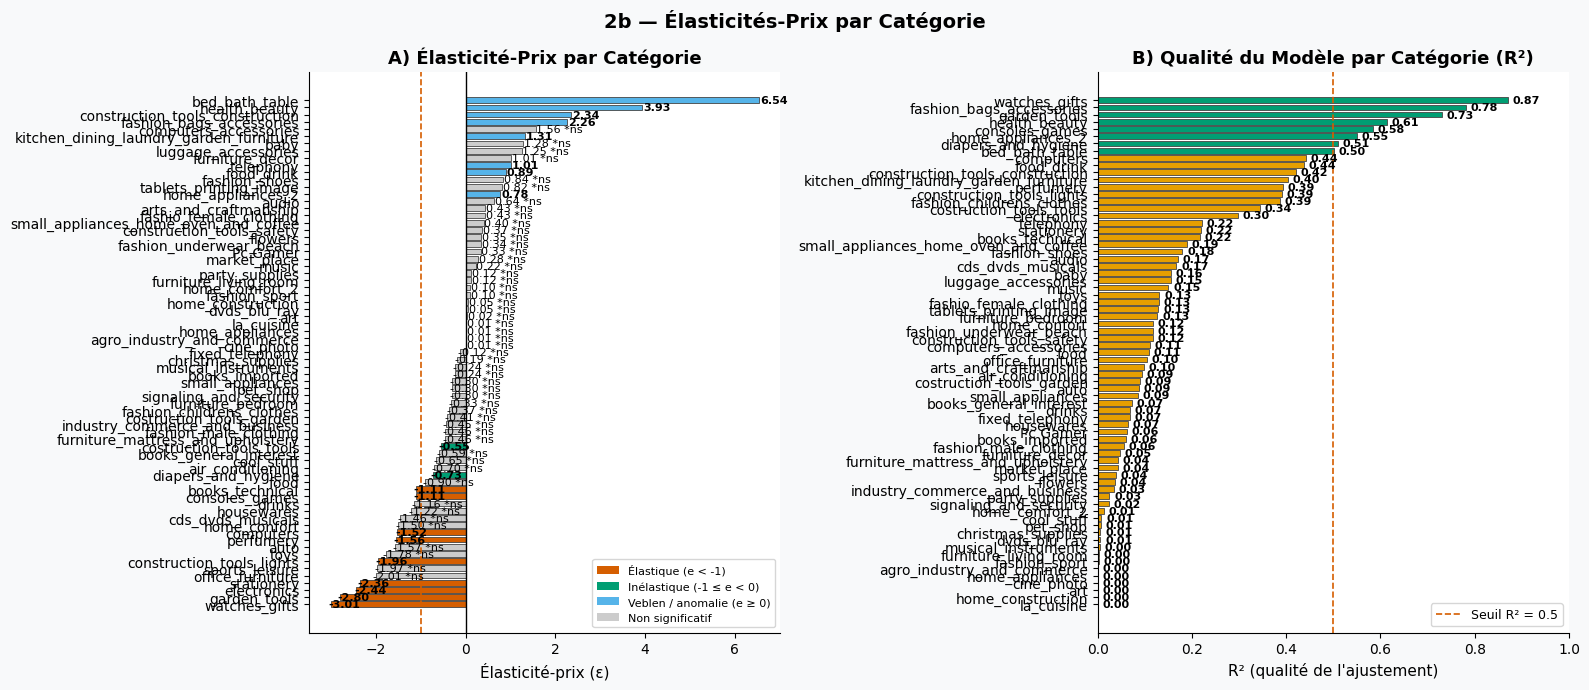

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("2b — Élasticités-Prix par Catégorie", fontsize=14, fontweight="bold")

# A) Graphique en cascade des élasticités
ax = axes[0]
plot_df = elasticity_df.sort_values("elasticity")
colors  = [
    PALETTE[5] if (e < -1 and sig)       # élastique  → vermillon
    else PALETTE[2] if (-1 <= e < 0 and sig)  # inélastique → vert
    else PALETTE[1] if (e >= 0 and sig)   # Veblen → bleu ciel
    else "#CCCCCC"                        # non significatif → gris
    for e, sig in zip(plot_df["elasticity"], plot_df["significant"])
]
bars = ax.barh(
    plot_df["category"], plot_df["elasticity"],
    color=colors, edgecolor="#444444", linewidth=0.6
)
ax.axvline(0,  color="black", lw=1.0, linestyle="-")
ax.axvline(-1, color=PALETTE[5], lw=1.2, linestyle="--",
           label="Seuil élasticité unitaire (e = -1)")
ax.set_xlabel("Élasticité-prix (ε)")
ax.set_title("A) Élasticité-Prix par Catégorie")
ax.legend(fontsize=9)
for bar, val, sig in zip(bars, plot_df["elasticity"], plot_df["significant"]):
    label = f"{val:.2f}" + ("" if sig else " *ns")
    x_pos = val - 0.05 if val < 0 else val + 0.02
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            label, va="center", fontsize=8,
            fontweight="bold" if sig else "normal")

# Légende colorée
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE[5], label="Élastique (e < -1)"),
    Patch(facecolor=PALETTE[2], label="Inélastique (-1 ≤ e < 0)"),
    Patch(facecolor=PALETTE[1], label="Veblen / anomalie (e ≥ 0)"),
    Patch(facecolor="#CCCCCC",  label="Non significatif"),
]
ax.legend(handles=legend_elements, fontsize=8, loc="lower right")

# B) R² par catégorie (qualité de l'ajustement)
ax = axes[1]
r2_df  = elasticity_df.sort_values("r2", ascending=True)
colors2 = [PALETTE[2] if r >= 0.5 else PALETTE[0] for r in r2_df["r2"]]
bars2  = ax.barh(
    r2_df["category"], r2_df["r2"],
    color=colors2, edgecolor="#444444", linewidth=0.6
)
ax.axvline(0.5, color=PALETTE[5], lw=1.2, linestyle="--",
           label="Seuil R² = 0.5")
ax.set_xlabel("R² (qualité de l'ajustement)")
ax.set_title("B) Qualité du Modèle par Catégorie (R²)")
ax.set_xlim(0, 1)
ax.legend(fontsize=9)
for bar, val in zip(bars2, r2_df["r2"]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f"{val:.2f}", va="center", fontsize=8, fontweight="bold")

plt.tight_layout()
save_fig("phase2b_elasticite.png")
plt.show()

  ✅ Sauvegardé : ../outputs/phase2b_courbes_demande.png


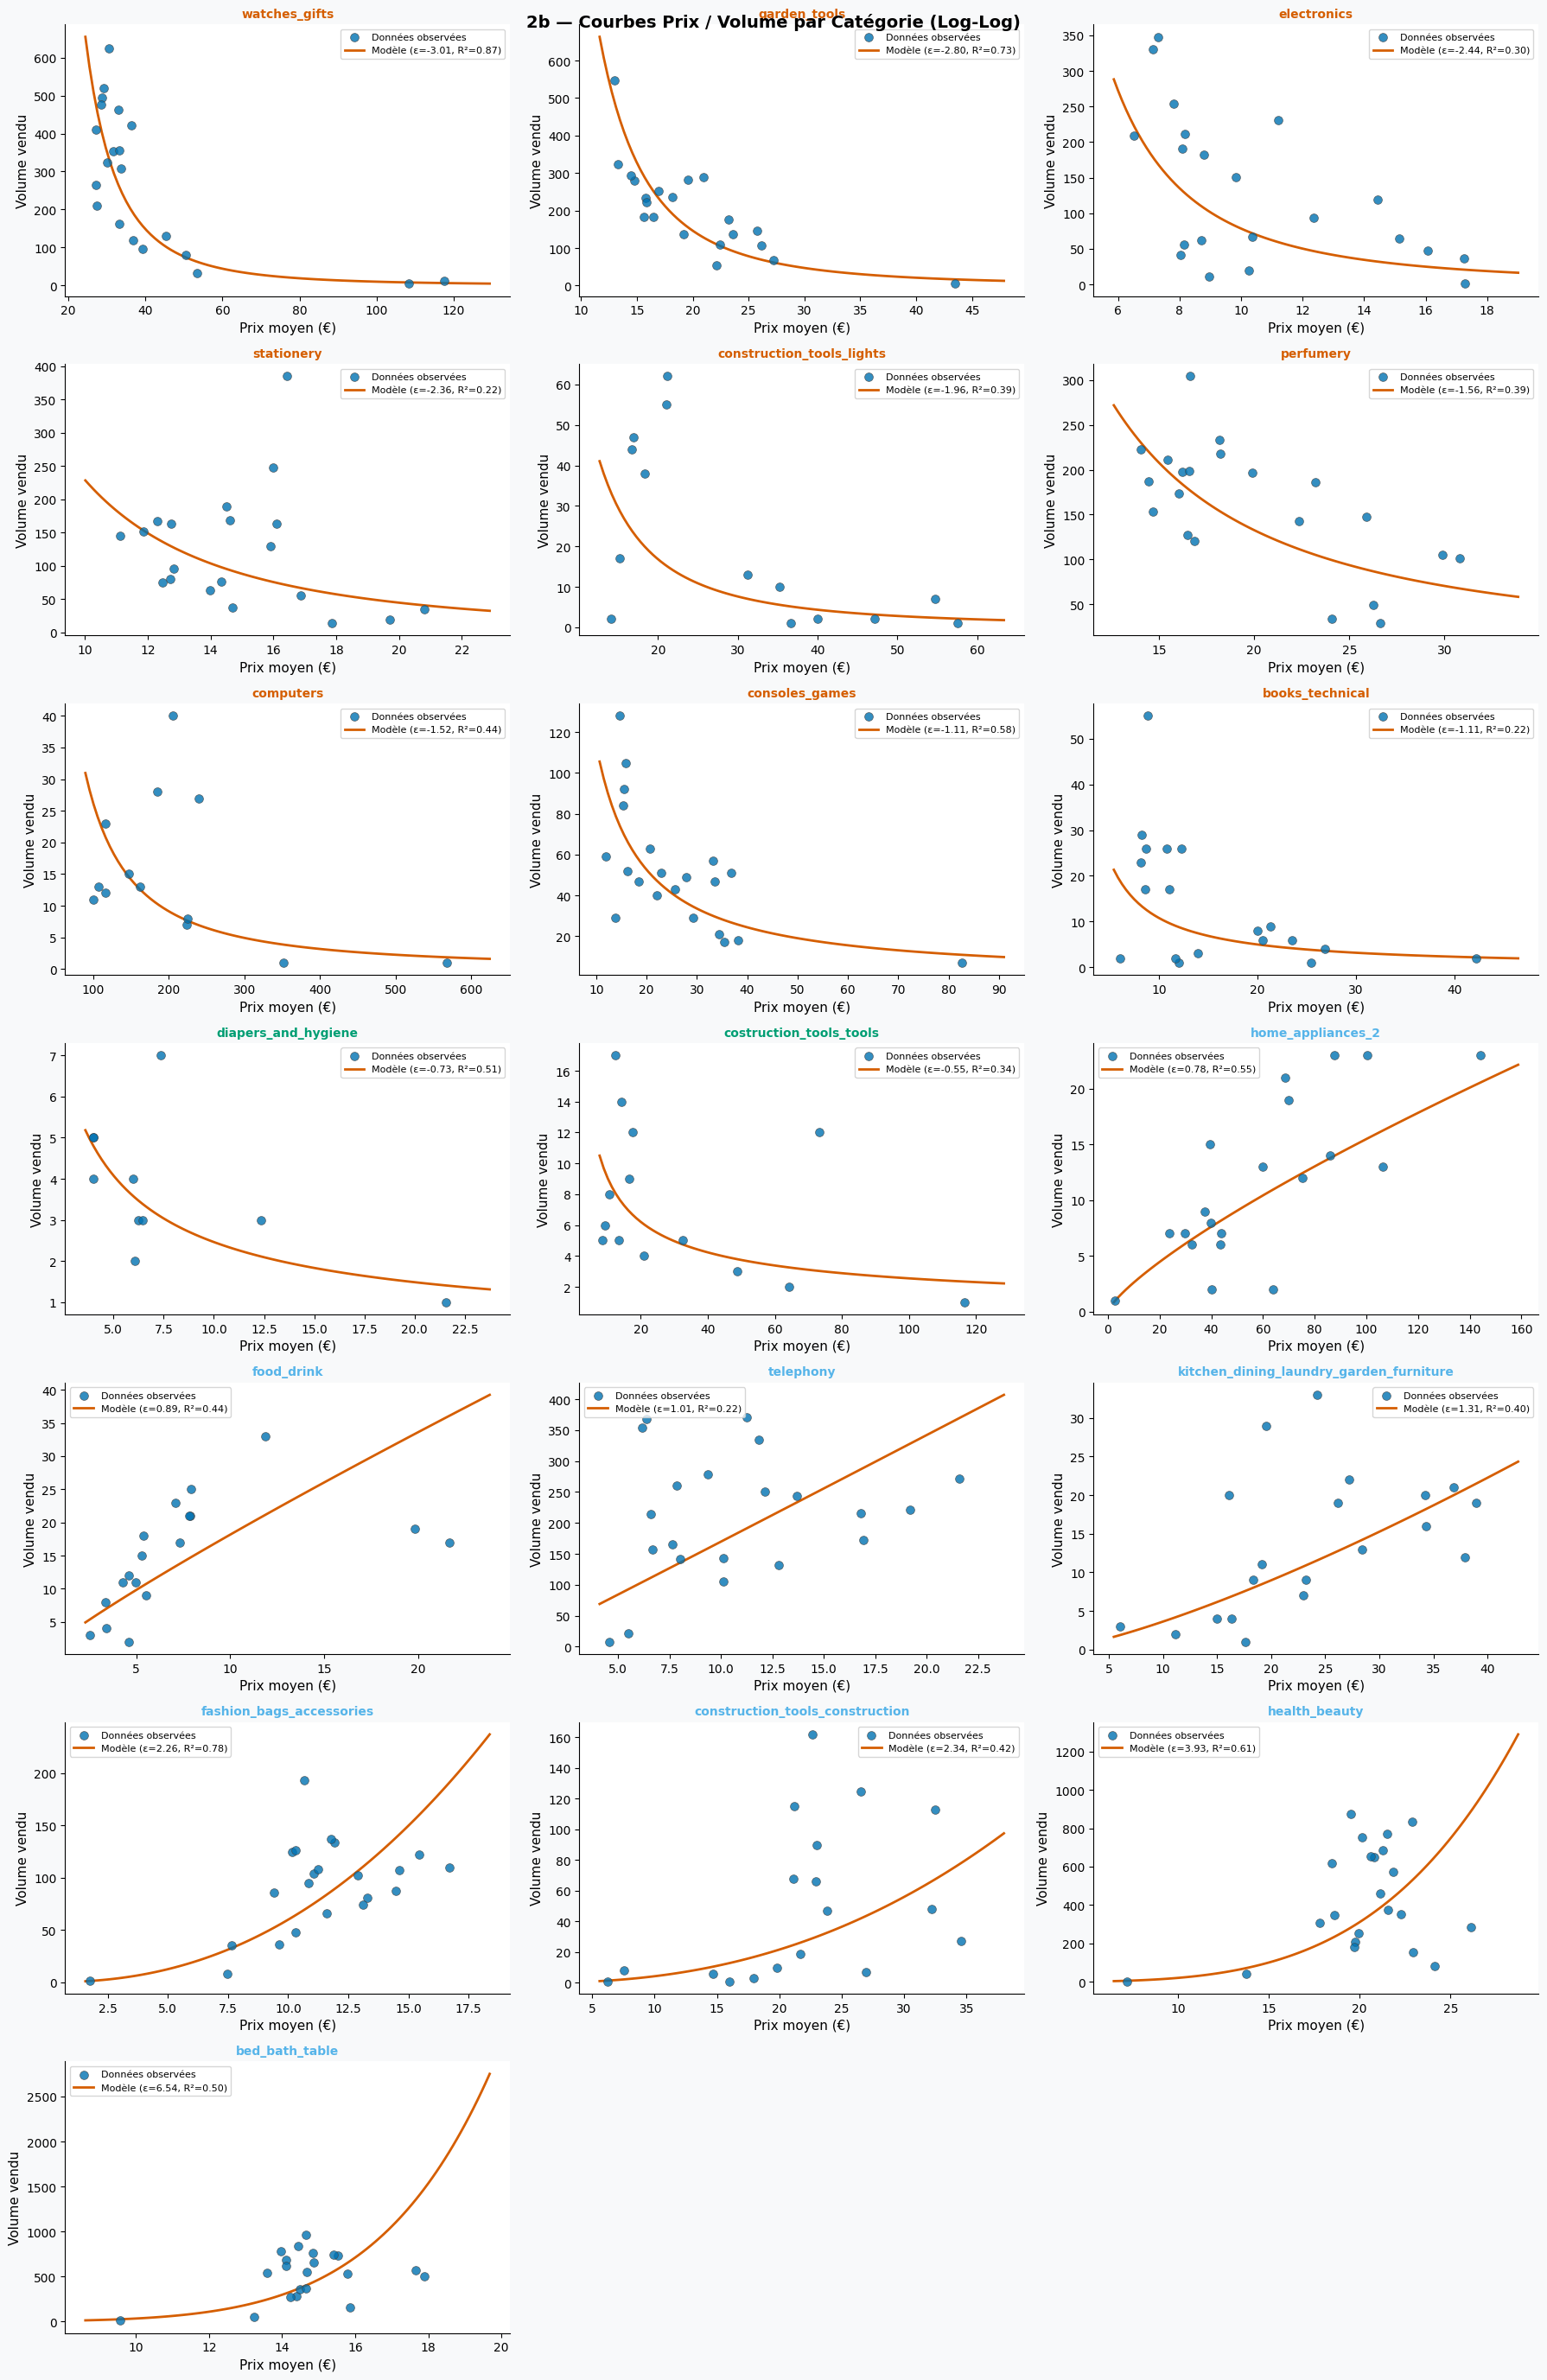

In [9]:
# ── Courbes demande/prix pour les catégories significatives ──
sig_cats = elasticity_df[elasticity_df["significant"]]["category"].tolist()
n_cats   = len(sig_cats)

if n_cats > 0:
    ncols = min(3, n_cats)
    nrows = (n_cats + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = np.array(axes).flatten() if n_cats > 1 else [axes]
    fig.suptitle("2b — Courbes Prix / Volume par Catégorie (Log-Log)",
                 fontsize=14, fontweight="bold")

    for i, cat in enumerate(sig_cats):
        ax   = axes[i]
        grp  = monthly_cat[monthly_cat["category_en"] == cat]
        row  = elasticity_df[elasticity_df["category"] == cat].iloc[0]
        e    = row["elasticity"]
        r2   = row["r2"]

        # Points observés
        ax.scatter(grp["avg_price"], grp["volume"],
                   color=PALETTE[4], s=50, alpha=0.8,
                   edgecolors="#444444", lw=0.5, label="Données observées", zorder=3)

        # Courbe ajustée (régression log-log retransformée)
        p_range = np.linspace(grp["avg_price"].min() * 0.9,
                              grp["avg_price"].max() * 1.1, 100)
        ln_p    = np.log(p_range)
        ln_q_hat = (
            np.polyfit(grp["ln_price"], grp["ln_volume"], 1)[1]
            + e * ln_p
        )
        ax.plot(p_range, np.exp(ln_q_hat),
                color=PALETTE[5], lw=2, label=f"Modèle (ε={e:.2f}, R²={r2:.2f})")

        # Couleur du titre selon type
        title_color = PALETTE[5] if e < -1 else PALETTE[2] if e < 0 else PALETTE[1]
        ax.set_title(cat, color=title_color, fontsize=10)
        ax.set_xlabel("Prix moyen (€)")
        ax.set_ylabel("Volume vendu")
        ax.legend(fontsize=8)

    # Masquer les axes vides
    for j in range(n_cats, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    save_fig("phase2b_courbes_demande.png")
    plt.show()

  ✅ Sauvegardé : ../outputs/phase2b_simulation_heatmap.png


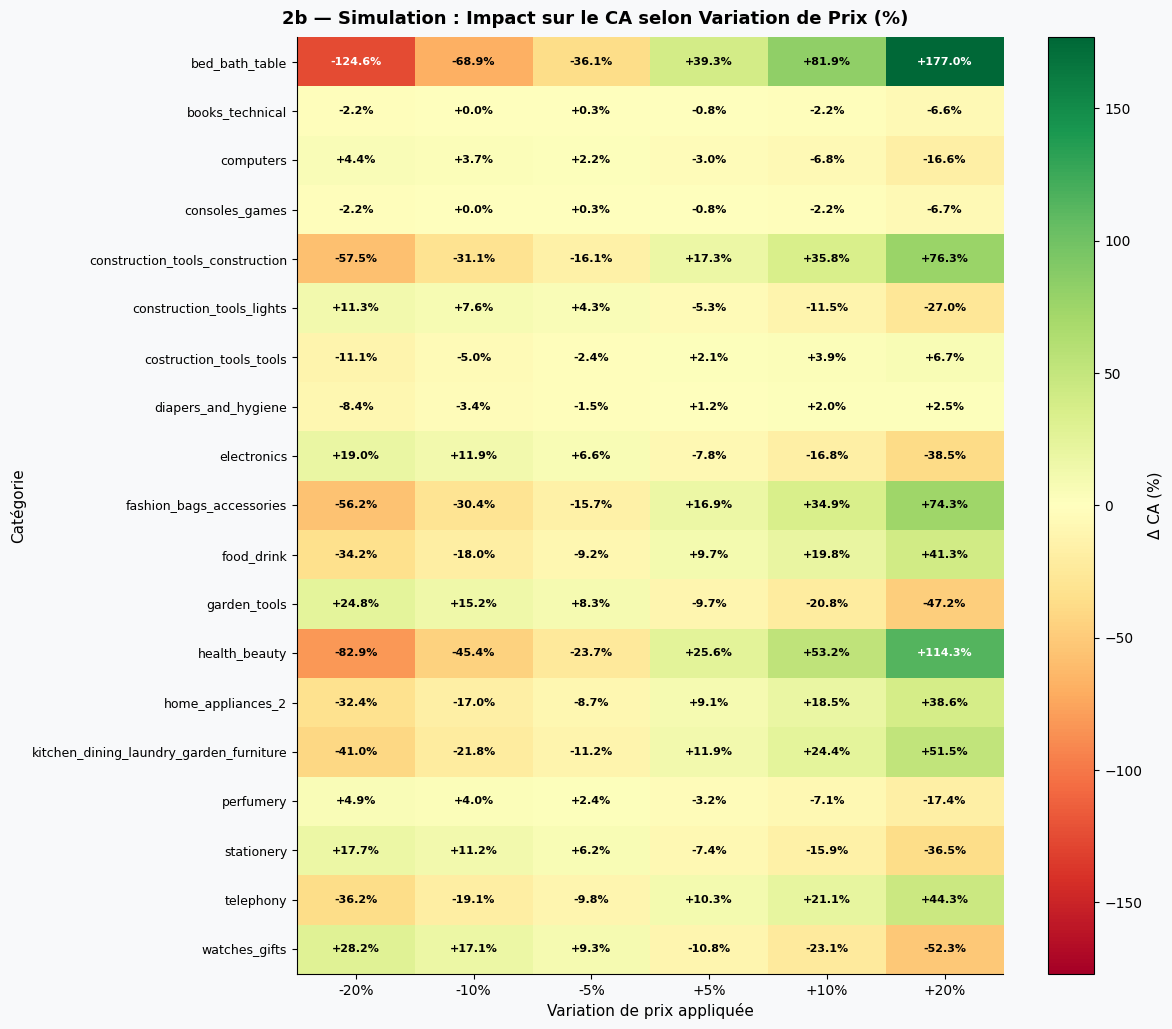

In [10]:
# ── Heatmap des scénarios : impact CA selon Δprix × catégorie ──
if not scenarios_df.empty:
    pivot = scenarios_df.pivot_table(
        index="category",
        columns="price_change_pct",
        values="delta_ca_pct"
    )
    # Réordonner les colonnes de -20% à +20%
    ordered_cols = ["-20%", "-10%", "-5%", "+5%", "+10%", "+20%"]
    pivot = pivot[[c for c in ordered_cols if c in pivot.columns]]

    fig, ax = plt.subplots(figsize=(12, max(4, len(pivot) * 0.55)))
    fig.suptitle("2b — Simulation : Impact sur le CA selon Variation de Prix (%)",
                 fontsize=13, fontweight="bold")

    # Heatmap manuelle avec matplotlib
    data   = pivot.values
    vmax   = max(abs(data[np.isfinite(data)]).max(), 1)
    im     = ax.imshow(data, cmap="RdYlGn", aspect="auto",
                       vmin=-vmax, vmax=vmax)

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, fontsize=10)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index, fontsize=9)
    ax.set_xlabel("Variation de prix appliquée")
    ax.set_ylabel("Catégorie")

    # Annotations des valeurs dans chaque cellule
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            val = data[r, c]
            if np.isfinite(val):
                txt_color = "black" if abs(val) < vmax * 0.6 else "white"
                ax.text(c, r, f"{val:+.1f}%",
                        ha="center", va="center",
                        fontsize=8, fontweight="bold", color=txt_color)

    plt.colorbar(im, ax=ax, label="Δ CA (%)")
    plt.tight_layout()
    save_fig("phase2b_simulation_heatmap.png")
    plt.show()

---
## 6. Synthèse & Recommandations

In [12]:
print("=" * 65)
print("📐 PHASE 2b — SYNTHÈSE ÉLASTICITÉ-PRIX")
print("=" * 65)

sig_df     = elasticity_df[elasticity_df["significant"]]
elastic    = sig_df[sig_df["elasticity"] < -1]
inelastic  = sig_df[(sig_df["elasticity"] >= -1) & (sig_df["elasticity"] < 0)]
veblen     = sig_df[sig_df["elasticity"] >= 0]

print(f"""
  RÉSULTATS
  • Catégories modélisées    : {len(elasticity_df)}
  • Dont significatives      : {len(sig_df)} (p < {ALPHA})
  • Élastiques (e < -1)      : {len(elastic)}
  • Inélastiques (-1 ≤ e < 0): {len(inelastic)}
  • Veblen / anomalie (e ≥ 0): {len(veblen)}
""")

if not elastic.empty:
    best_elastic = elastic.nsmallest(1, "elasticity").iloc[0]
    print(f"  💡 LEVIER DE CROISSANCE VOLUME")
    print(f"     '{best_elastic['category']}' (ε = {best_elastic['elasticity']:.2f})")
    print(f"     → Une baisse de prix de 10% générerait "
          f"+{abs(best_elastic['elasticity']) * 10:.1f}% de volume.")

if not inelastic.empty:
    best_inelastic = inelastic.nlargest(1, "elasticity").iloc[0]
    impact = scenarios_df[
        (scenarios_df["category"] == best_inelastic["category"]) &
        (scenarios_df["price_change"] == 0.10)
    ]
    delta_ca = float(impact["delta_ca_eur"].values[0]) if not impact.empty else 0
    print(f"\n  💡 LEVIER DE MARGE")
    print(f"     '{best_inelastic['category']}' (ε = {best_inelastic['elasticity']:.2f})")
    print(f"     → Une hausse de prix de +10% augmenterait le CA "
          f"de ~{delta_ca:,.0f} € avec peu d'impact volume.")

print(f"""
  ⚠️  LIMITES DU MODÈLE
  • Pas de contrôle des facteurs externes (saisonnalité, concurrence)
  • Période courte (2017-2018) — à revalider avec données récentes
  • Estimations directionnelles, non causales
""")

📐 PHASE 2b — SYNTHÈSE ÉLASTICITÉ-PRIX

  RÉSULTATS
  • Catégories modélisées    : 71
  • Dont significatives      : 19 (p < 0.05)
  • Élastiques (e < -1)      : 9
  • Inélastiques (-1 ≤ e < 0): 2
  • Veblen / anomalie (e ≥ 0): 8

  💡 LEVIER DE CROISSANCE VOLUME
     'watches_gifts' (ε = -3.01)
     → Une baisse de prix de 10% générerait +30.1% de volume.

  💡 LEVIER DE MARGE
     'costruction_tools_tools' (ε = -0.55)
     → Une hausse de prix de +10% augmenterait le CA de ~99 € avec peu d'impact volume.

  ⚠️  LIMITES DU MODÈLE
  • Pas de contrôle des facteurs externes (saisonnalité, concurrence)
  • Période courte (2017-2018) — à revalider avec données récentes
  • Estimations directionnelles, non causales

